<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W2D1_BayesianStatistics/W2D1_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMA 2020 W2D1 -- Tutorial 3: Bayesian Decision Theory & Cost functions

**Tutorial Lecturer:** *Konrad Kording*

**Tutorial Content Creator:** *Vincent Valton*

## a. Introduction

Video available at https://youtube.com/watch?v=z2DF4H_sa-k


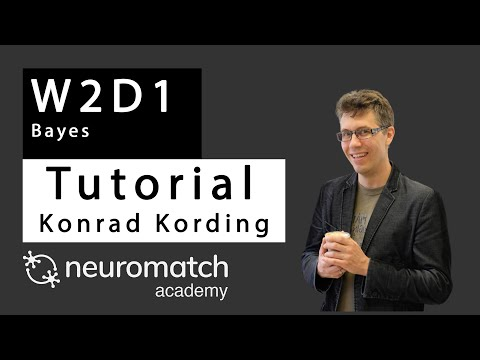

In [1]:
#@title Video 1: Introduction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='z2DF4H_sa-k', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
### Tutorial Objectives
In the previous tutorials, we investigated the posterior, which summarizes our beliefs based on current evidence and prior experience. This tutorial focuses on Bayesian Decision Theory, which combines the posterior with **cost functions** that allow us to quantify the potential impact of making a decision or choosing an action based on that posterior.

In this tutorial, you will
  1. Implement three commonly-used cost functions: mean-squared error, absolute error, and zero-one loss
  2. Discover the concept of expected loss, and
  3. Choose optimal locations on the posterior that minimize these cost functions. You will verify that it these locations can be found analytically as well as empirically.

---
Please execute the cell below to initialize the notebook environment


--- 
### Setup

In [2]:
# Imports
import numpy as np                 
import matplotlib.pyplot as plt    
import matplotlib as mpl

In [3]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'

In [4]:
# @title Helper Functions

def my_gaussian(x_points, mu, sigma):
  """Returns un-normalized Gaussian estimated at points `x_points`
  
  DO NOT EDIT THIS FUNCTION !!!

  Args : 
    x_points (numpy array of floats) - points at which the gaussian is evaluated
    mu (scalar) - mean of the Gaussian
    sigma (scalar) - std of the gaussian

  Returns:
    (numpy array of floats): un-normalized Gaussian (i.e. without constant) evaluated at `x`
  """
  return np.exp(-(x_points-mu)**2/(2*sigma**2))

def visualize_loss_functions(mse=None, abse=None, zero_one=None):
  """Visualize loss functions
    Args:
      - mse (func) that returns mean-squared error
      - abse: (func) that returns absolute_error
      - zero_one: (func) that returns zero-one loss
    All functions should be of the form f(x, x_hats). See Exercise #1.
    
    Returns:
      None
    """

  x = np.arange(-3, 3.25, 0.25)

  fig, ax = plt.subplots(1)
  
  if mse is not None:
    ax.plot(x, mse(0, x), linewidth=2, label="Mean Squared Error")
  if abse is not None:
    ax.plot(x, abse(0, x), linewidth=2, label="Absolute Error")
  if zero_one_loss is not None:
    ax.plot(x, zero_one_loss(0, x), linewidth=2, label="Zero-One Loss")

  ax.set_ylabel('Cost')
  ax.set_xlabel('Predicted Value ($\hat{x}$)')
  ax.set_title("Loss when the true value $x$=0")
  ax.legend()
  plt.show()

def moments_myfunc(x_points, function):
    """Returns the mean, median and mode of an arbitrary function
    
    DO NOT EDIT THIS FUNCTION !!!

    Args : 
      x_points (numpy array of floats) - x-axis values
      function (numpy array of floats) - y-axis values of the function evaluated at `x_points`

    Returns:
       (tuple of 3 scalars): mean, median, mode
    """

    # Calc mode of an arbitrary function
    mode = x_points[np.argmax(function)]

    # Calc mean of an arbitrary function
    mean = np.sum(x_points * function)

    # Calc median of an arbitrary function
    cdf_function = np.zeros_like(x_points)
    accumulator = 0
    for i in np.arange(x.shape[0]):
        accumulator = accumulator + posterior[i]
        cdf_function[i] = accumulator
    idx = np.argmin(np.abs(cdf_function - 0.5))
    median = x_points[idx]

    return mean, median, mode

def loss_plot(x, loss, min_loss, loss_label, show=False, ax=None):
  if not ax:
    fig, ax = plt.subplots(1, figsize=(fig_w, fig_h))

  ax.plot(x, loss, '-r', linewidth=2, label=loss_label)
  ax.axvline(min_loss, ls='dashed', color='red', label='Minimum')
  ax.set_ylabel('Expected Loss')
  ax.set_xlabel('Orientation (Degrees)')
  ax.legend()

  if show:
    plt.show()

def pmoments_plot(x, posterior, 
                  prior=None, likelihood=None, show=False, ax=None):
  
  if not ax:
    fig, ax = plt.subplots(1, figsize=(fig_w, fig_h))


  if prior:
    ax.plot(x, prior, '-r', linewidth=2, label='Prior')
  if likelihood:
    ax.plot(x, likelihood, '-b', linewidth=2, label='Likelihood')
  ax.plot(x, posterior, '-g', linewidth=4, label='Posterior')
  
  mean, median, mode = moments_myfunc(x, posterior)

  ax.axvline(mean, ls='dashed', color='red', label='Mean')
  ax.axvline(median, ls='dashdot', color='blue', label='Median')
  ax.axvline(mode, ls='dotted', color='green', label='Mode')
  ax.set_ylabel('Probability')
  ax.set_xlabel('Orientation (Degrees)')
  ax.legend()

  if show:
    plt.show()


def loss_and_pmoments_plot(x, loss, min_loss, loss_label, 
                          posterior, likelihood=None, prior=None):
  
  """"Generate two-panel plots for each exercise."""

  # Plotting snippet 
  fig_w, fig_h = plt.rcParams["figure.figsize"]
  fig, ax = plt.subplots(2, figsize=(fig_w, fig_h * 2), sharex=True)

  loss_plot(x, loss, min_loss, loss_label,ax=ax[0])
  pmoments_plot(x, posterior, prior, likelihood, ax=ax[1])
 
  plt.show()

  return fig


def generate_example_pdfs():
  """Generate example probability distributions as in T2"""
  x=np.arange(-5, 5, 0.01)

  prior_mean = 0
  prior_sigma1 = .5
  prior_sigma2 = 3
  prior1 = my_gaussian(x, prior_mean, prior_sigma1)
  prior2 = my_gaussian(x, prior_mean, prior_sigma2)

  alpha = 0.05
  prior_combined = (1-alpha) * prior1 + (alpha * prior2) 
  prior_combined = prior_combined / np.sum(prior_combined)

  likelihood_mean = -2.7
  likelihood_sigma = 1
  likelihood = my_gaussian(x, likelihood_mean, likelihood_sigma)
  likelihood = likelihood / np.sum(likelihood)

  posterior = prior_combined * likelihood
  posterior = posterior / np.sum(posterior)

  return x, prior_combined, likelihood, posterior 

def plot_posterior_components(x, prior, likelihood, posterior):
  fig = plt.figure(figsize=(fig_w, fig_h))
  plt.plot(x, prior, '-r', linewidth=2, label='Prior')
  plt.plot(x, likelihood, '-b', linewidth=2, label='Likelihood')
  plt.plot(x, posterior, '-g', linewidth=4, label='Posterior')
  plt.legend()
  plt.title('Sample Output')
  plt.show()
  return


### The Posterior Distribution

This notebook will reuse the model struture developed in Tutorial 2. Specifically, our model will consist of these components, combined according to Bayes' rule:
$$
\begin{eqnarray}
\textrm{Prior} &=& \begin{cases} N(0, 0.5) & 95\% \textrm{ weight}\\
                                 N(0, 3.0) &  5\% \textrm{ weight} \\
                    \end{cases}\\
\textrm{Likelihood} &= &N(-2.7, 1.0)
\end{eqnarray}
$$

We will use this posterior as an an example through this notebook.Please run the cell below to import and plot the model. You do not need to edit anything. 



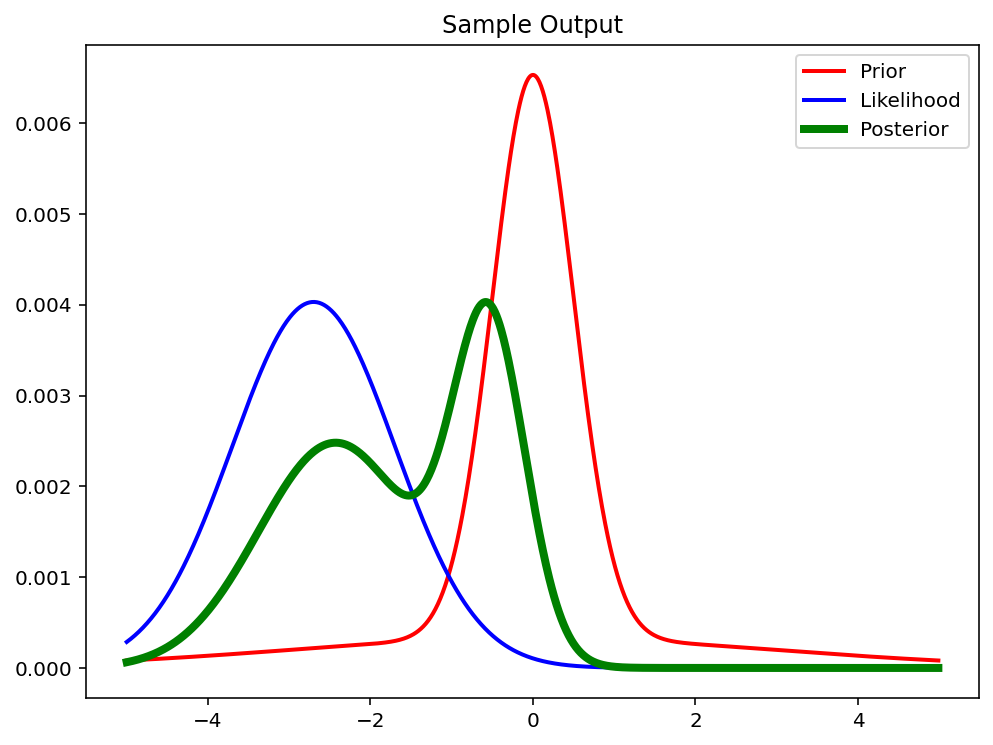

In [5]:
x, prior, likelihood, posterior = generate_example_pdfs()
plot_posterior_components(x, prior, likelihood, posterior)

## b. The Cost Functions

Next, we will implement the cost functions. The formulas below describe the "cost" of estimating $\hat{x}$ when the true or correct quantity is really $x$,  
$$\begin{eqnarray}
\textrm{Mean Squared Error} &=& (x - \hat{x})^2 \\ 
\textrm{Absolute Error} &=& \big|x - \hat{x}\big| \\ 
\textrm{Zero-One Loss} &=& \begin{cases}
                            0,& \text{if } x = \hat{x} \\
                            1,              & \text{otherwise}
                            \end{cases}
\end{eqnarray}
$$

In the cell below, fill in the body of these cost function. Each  should take a one value for $x$ and one or more possible values for $\hat{x}$. Return an array containing the costs associated with predicting $\hat{x}$ when the true value is $x$. Once you have written all three functions, uncomment the final line to visulize your results.

 _Hint:_ These functions are easy to write (1 line each!) but be sure *all* three functions return arrays of `np.float` rather than another data type.

In [6]:
#@title Exercise 1
def mse(x, x_hats):
    """Mean squared error (MSE) cost function
    Args:
      x: One true value of $x$
      x_hats: Estimate of x
    Returns:
      ndarray: MSE costs associated with predicting x_hats instead of x$
    """

    #### Remove the line below and replace it with your function 
    raise NotImplementedError("You need to complete this function!")


def abs_err(x, x_hats):
    """Absolute error cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x 
    Returns:
      ndarray (same shape as x_hats): absolute error costs associated with predicting x_hats instead of x$
    """

    #### Remove the line below and replace it with your function 
    raise NotImplementedError("You need to complete this function!")

def zero_one_loss(x, x_hats):
    """Zero-One loss cost function
    Args:
      x (scalar): One true value of $x$
      x_hats (scalar or ndarray): Estimate of x 
    Returns:
      ndarray (same shape as x_hats): 0-1 Loss costs associated with predicting x_hats instead of x$
    """

    #### Remove the line below and replace it with your function 
    raise NotImplementedError("You need to complete this function!")

# When you are done with the functions above, uncomment the line below to visualize them
# visualize_loss_functions(mse, abs_err, zero_one_loss)


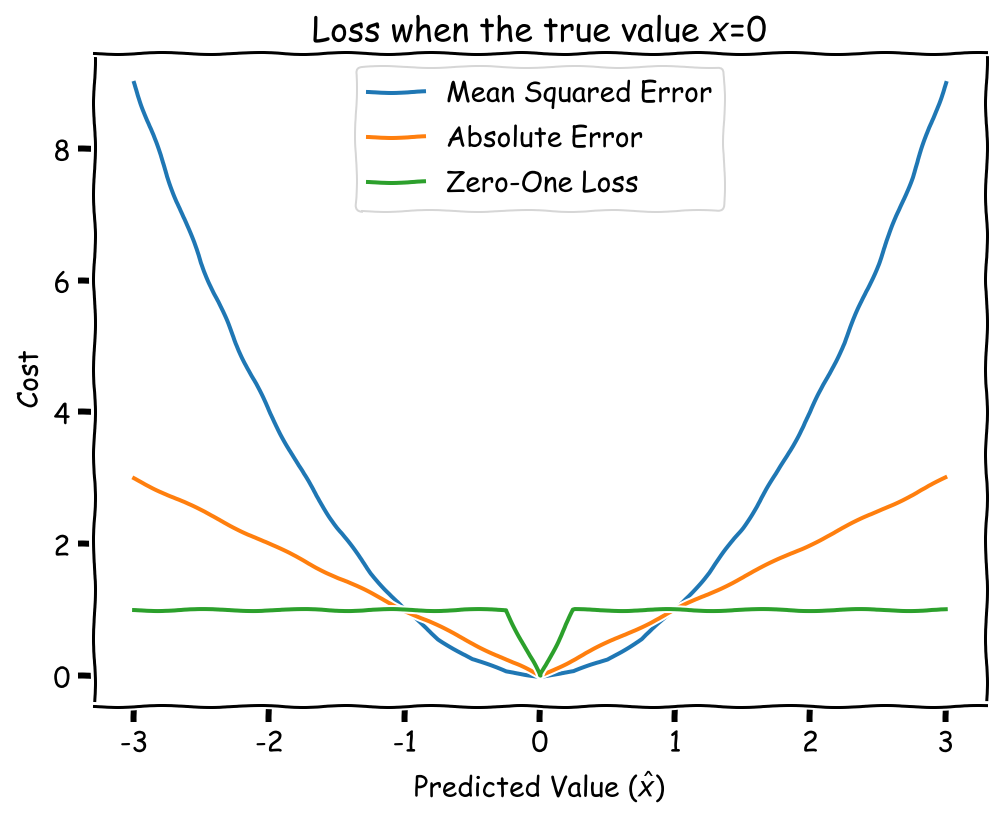

In [7]:
# to_remove solution
def mse(x, x_hats):
    """Mean squared error (MSE) cost function
    Args:
      x: One true value of $x$
      x_hat: Estimate of $x$
    Returns:
      ndarray of the MSE costs associated with predicting x_hat instead of x$
    """
    return (x - x_hats)**2

def abs_err(x, x_hats):
    """Absolute error  cost function
    Args:
      x (scalar): One true value of $x$
      x_hat (scalar or ndarray): Estimate of $x$ 
    Returns:
      ndarray of the absolute error costs associated with predicting x_hat instead of x$
    """
    return np.abs(x - x_hats)

def zero_one_loss(x, x_hats):
  """Zero-One Loss cost function
    Args:
      x (scalar): One true value of $x$
      x_hat (scalar or ndarray): Estimate of $x$ 
    Returns:
      ndarray of the 0-1 Loss costs associated with predicting x_hat instead of x$
    """
  return (x != x_hats).astype(np.float)

with plt.xkcd():
  visualize_loss_functions(mse, abs_err, zero_one_loss)


---
## c. Expected Loss
    


Video available at https://youtube.com/watch?v=FTBpCfylV_Y


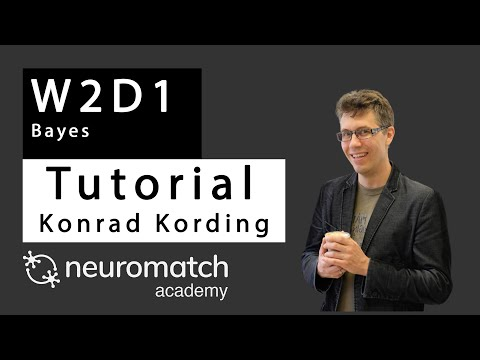

In [8]:
#@title Video 2: Expected Loss
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='FTBpCfylV_Y', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

A posterior distribution tells us about the confidence or credibility we assign to different choices. A cost function describes the penalty we incur when choosing an incorrect option. These concepts can be combined into an *expected loss* function. Expected loss is defined as  
$$
\begin{eqnarray}
    \mathbb{E}[\text{Loss} | \hat{x}] = \int L[\hat{x},x] \odot  p(x|\tilde{x}) dx
\end{eqnarray}
$$
where $L[ \hat{x}, x]$ is the loss function, $p(x|\tilde{x})$ is the posterior, and $\odot$ represents the [Hadamard Product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) (i.e., elementwise multiplication).

In the next exercise, we will calculate the expected mean squared MSE loss error for over posterior. 
* Calculate the mean squared error (MSE) loss between the $\hat{x}$ estimate & all $x$ values
* Compute the expected MSE loss ($\mathbb{E}[MSE Loss]$) using your posterior (imported above as `posterior`) & your MSE loss 
* Find the x position that minimizes the expected loss for the mean squared error.

**Helper function(s)**

###Exercise 2

In [9]:
x = np.arange(-5, 5, 0.01)

# mean, median, mode = ...
# print(f"Posterior mean is : {mean:.2f}, Posterior median is : {median:.2f}, Posterior mode is : {mode:.2f}")

ExpectedLoss_MSE = np.zeros_like(x)
min_MSE = float("NaN")

#Looping over potential x_hats ('decisions')
for idx in np.arange(x.shape[0]):
  estimate = x[idx] 

  #MSELoss = ... # reuse your function from Exercise 1 to calculate the loss between your estimate and all $x$
  #ExpectedLoss_MSE[idx] = ... # the posterior is available as `posterior`

# min_MSE = ... #Find the minimum expected loss.

print(f"Minimum of MSE is : {min_MSE:.2f}")
# Uncomment this line to plot the expected loss as a function of the estimates
# loss_plot(x, ExpectedLoss_MSE, min_MSE, "Mean Squared Error")

Minimum of MSE is : nan


Minimum of MSE is : -1.65


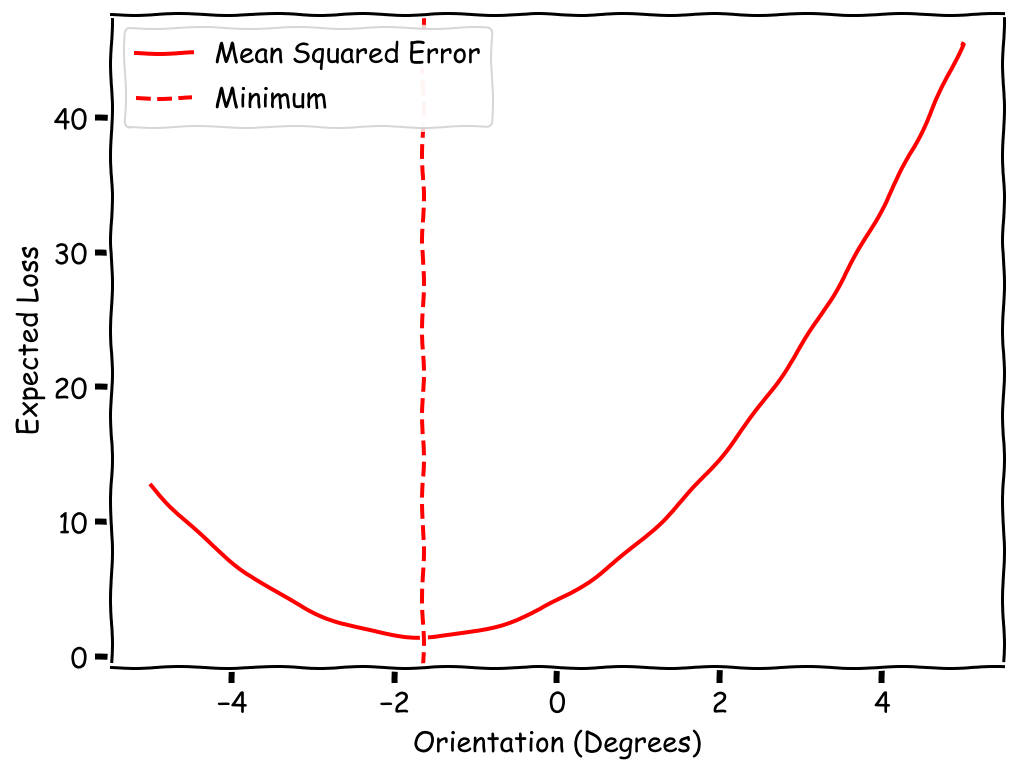

In [10]:
# to_remove solution

x=np.arange(-5, 5, 0.01)

ExpectedLoss_MSE = np.zeros_like(x)

for idx in np.arange(x.shape[0]):
    estimate = x[idx]

    MSELoss = mse(estimate, x)
    ExpectedLoss_MSE[idx] = np.sum(MSELoss * posterior)

min_MSE = x[np.argmin(ExpectedLoss_MSE)]

print(f"Minimum of MSE is : {min_MSE:.2f}")

# Plotting snippet
with plt.xkcd():
  loss_plot(x, ExpectedLoss_MSE, min_MSE, "Mean Squared Error")

---
## d. Analytical Solutions
    

Video available at https://youtube.com/watch?v=wmDD51N9rs0


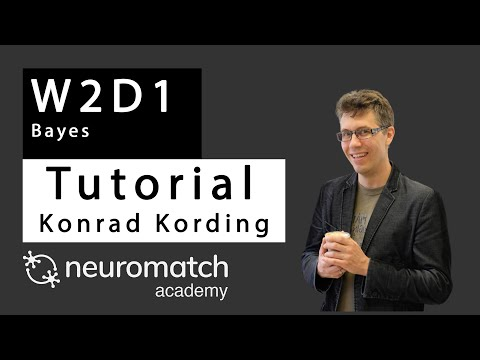

In [11]:
#@title Video 3: Analytical Solutions 
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='wmDD51N9rs0', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

In the previous exercise, we found the minimum expected loss via brute-force: we searched over all possible values of $x$. 

However, the three loss functions examined in this tutorial have closed-form analytical solutions, corresponding to the mean (MSE), median (absolute error) and mode (zero-one loss) of the posterior. 

In this exercise, we will going to verify that property.
 
*   We provide you with a helper functions: `moments_myfunc`, which returns the mean, median, and mode of a distribution (such as your posterior). Use these quantities to predict the optimal location under each cost function. 
* Adapt the code you wrote in Exercise 2 to empirically search for the optimal location under that cost function
* Compare the analytical and empircal solutions. We provide plotting code that will visualize them. Uncomment the last line, when the rest of your code is complete. 
* Try this for each of MSE, absolute error, and zero-one loss. 




###Exercise

In [12]:
x=np.arange(-5, 5, 0.01)


################################################################################
# Finish the lines below to analytically find the optimum location
################################################################################
# mean, median, mode = ...
# print(f"Posterior mean is : {mean:.2f}, Posterior median is : {median:.2f}, Posterior mode is : {mode:.2f}")

expected_loss= np.zeros_like(x)
min_loss_location = float("NaN")


for idx in np.arange(x.shape[0]):
  estimate = x[idx] #This is your current x_hat estimate for which you want to estimate the Expected Loss
################################################################################
## Fill in these lines to search for the lowest expected loss empirically
  #loss = ... #Use the loss functions from Exercise #1
  #expected_loss[idx] = ...

#min_loss_location = ...
################################################################################
print(f"Minimum of the loss is at : {min_loss_location:.2f}")

# Uncomment this to plot
#loss_and_pmoments_plot(x, expected_loss, min_loss_location, "Absolute Error", posterior)

Minimum of the loss is at : nan


Posterior mean is : -1.65, Posterior median is : -1.50, Posterior mode is : -0.58
Minimum of Abs_error is : -0.58


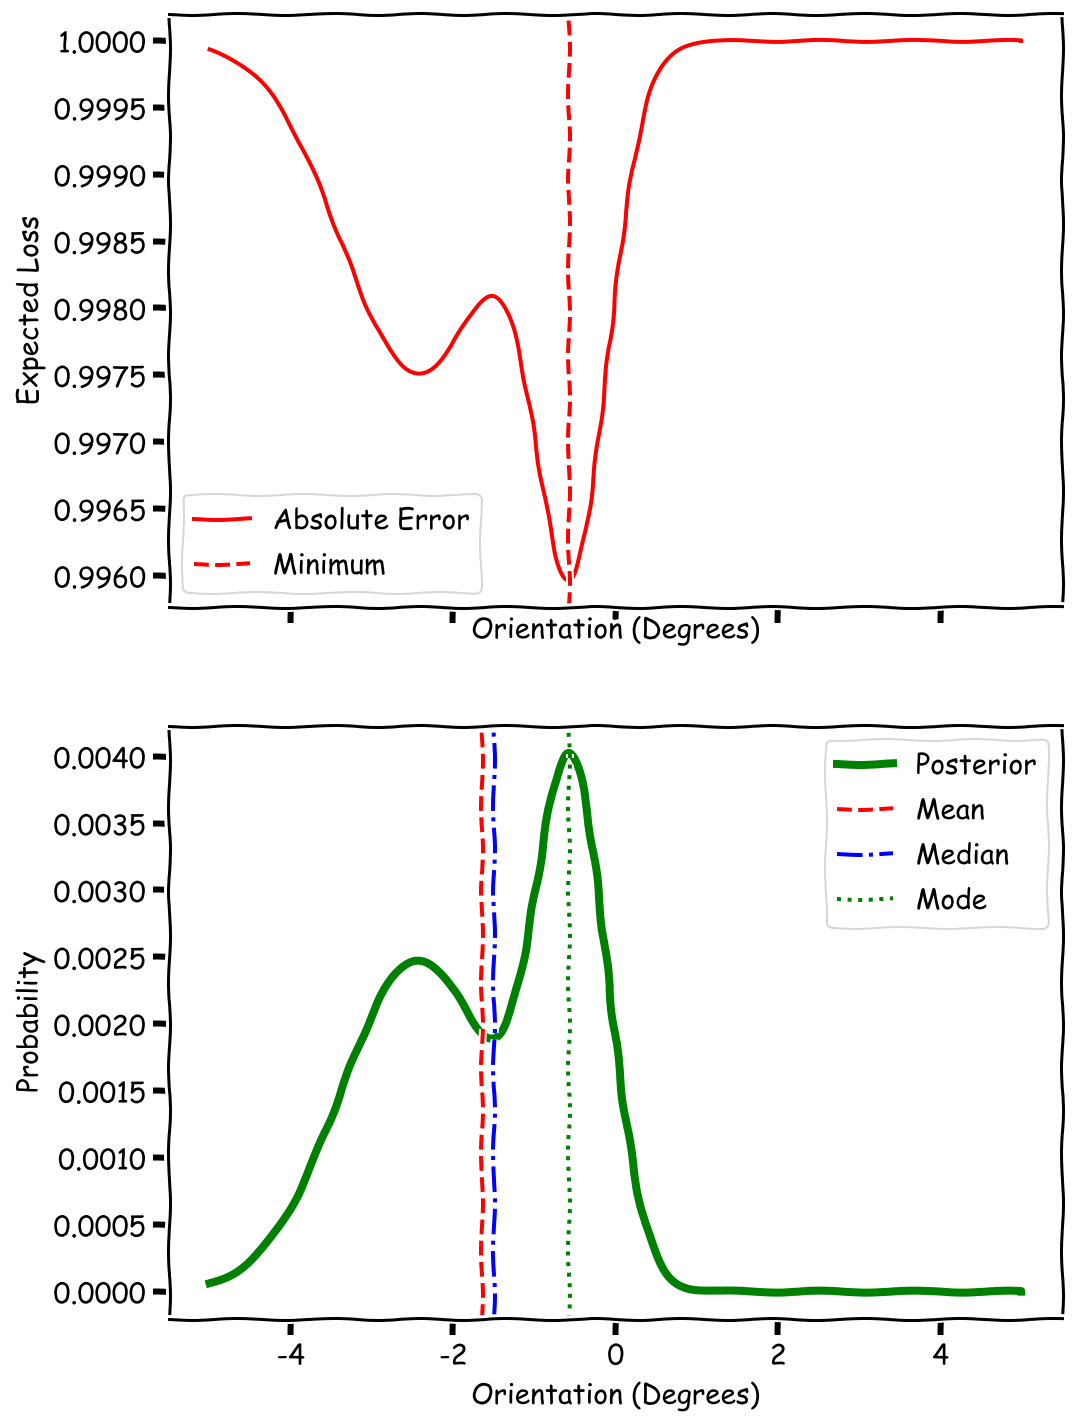

In [13]:
# to_remove

x=np.arange(-5,5,0.01)

mean, median, mode = moments_myfunc(x, posterior)
print(f"Posterior mean is : {mean:.2f}, Posterior median is : {median:.2f}, Posterior mode is : {mode:.2f}")

expected_loss = np.zeros_like(x)

for idx in np.arange(x.shape[0]):
    estimate = x[idx]

    loss = zero_one_loss(estimate, x) # or mse or zero_one_loss
    expected_loss[idx] = np.sum(loss * posterior)

min_loss_location = x[np.argmin(expected_loss)]

print(f"Minimum of Abs_error is : {min_loss_location:.2f}")

with plt.xkcd():
  loss_and_pmoments_plot(x, expected_loss, min_loss_location, "Absolute Error", posterior)

---
## e. Conclusion


Video available at https://youtube.com/watch?v=3nTvamDVx2s


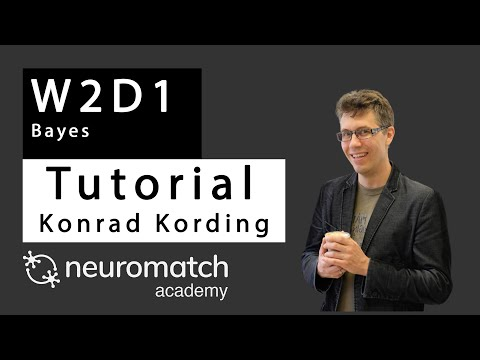

In [14]:
#@title Video 4: Conclusion
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='3nTvamDVx2s', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Think!
In this tutorial, we learned about three kinds of cost functions: mean-squared error, absolute error, and zero-one loss. We used expected loss to quantify the results of making a decision, and showed that optimizing under different cost functions led us to choose different locations on the posterior. Finally, we found that these optimal locations can be identified analytically, sparing us from a brute-force search. 

If you have additional time, here some additional topics to think about

*   Suppose your professor offered to score an exam with zero-one loss or mean square error. 
    * When might you choose each?
    * Which would be easier to learn from?
* All of the loss functions we considered are symmetrical. Are there situations where an asymmetrical loss function might make sense? How about a negative one?







